In [ ]:
!pip3 uninstall -y spacy tokenizers pytorch-lightning torchtext
!pip3 install spacy tokenizers pytorch-lightning==0.9.0
!python3 -m spacy download ru_core_news_sm
!python3 -m spacy download en

In [ ]:
import re
import spacy
from spacy.tokenizer import Tokenizer
spacyRu = spacy.load('ru_core_news_sm')

import string
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.options.display.max_colwidth = 100
import csv
import json
import glob
from nltk.tokenize import WordPunctTokenizer

from google.colab import drive
drive.mount('/content/drive')
!pip install stanza nltk

import stanza
stanza.download('ru')

import nltk
from nltk.tokenize import sent_tokenize 
nltk.download('punkt')
nlp = stanza.Pipeline(lang='ru', processors='tokenize')
import difflib


In [ ]:
import os
import sys
# REPO_PATH = "/content/drive/MyDrive/Diploma_paper/mrc_preprocess_wanglaiki/mrc-wanglaiki"
REPO_PATH = "/content/drive/MyDrive/Diploma_paper/mrc-for-flat-nested-ner-master"
SBERT_PATH = "/content/drive/MyDrive/Diploma_paper/sbert_large_nlu_ru"
os.environ['PYTHONPATH'] += ":" + REPO_PATH + ":" + SBERT_PATH
sys.path.insert(1, REPO_PATH)

In [ ]:
forbidden_symbols = {'\t':' ', '\r':' ', '\f':' ', '\xa0':' ', '\n':' ', '=—':'  ', "\|":" ",'サ':" ",
 'ミ':" ", 'ヲ':" ", '一':" ", '三':" ", '中':" ", '丹':" ", '二':" ", '京':" ", '代':" ", '何':" ", '作':" ", '先':" ",
 '凌':" ", '前':" ", '友':" ", '右':" ", '君':" ", '咪':" ", '国':" ", '大':" ", '字':" ", '富':" ", '少':" ", '川':" ",
 '市':" ", '年':" ", '後':" ", '恵':" ", '木':" ", '村':" ", '次':" ", '浦':" ", '澤':" ", '猷':" ", '琳':" ", '章':" ",
 '美':" ", '聯':" ", '莹':" ", '蒙':" ", '衛':" ", '袁':" ", '郎':" ", '里':" ", '锋':" ", '門':" ", '队':" ", '雄':" ", '頭':" ", '颖':" ", '马':" ",
 'É':' ', '×':' ', 'á':' ', 'ä':' ', 'ç':' ', 'è':' ', 'é':' ', 'í':' ', 'ó':' ', 'ô':' ', 'ú':' ',
'ü':' ', 'ć':' ', 'Š':' ', 'š':' ', 'ʼ':' ', '́':' ', 'є':' ', 'ғ':' ', 'ב':' ',
'ד':" ",
'ה':' ',
'ו':' ',
'ח':' ',
'י':' ',
'ל':' ',
'ם':' ',
'ס':' ',
'פ':' ',
'צ':' ',
'ר':' ',
'ת':' ',
'ا':' ',
'ح':' ',
'ر':' ',
'ف':' ',
'ل':' ',
'م':' ',
'ن':' ',
'و':' ',
'ی':' ', '\u2002':' ', '\u2009':' ', '\u200b':' ', '\u202f':' ', '▶':' ',
'«\'\'':' «\'', '\'\'»':'\'» ',
"(''": "( '", "'')": "' )", 
"—":"-",
'\xad':' '
}

emoticons = r'(?:[:;=\^\-oO][\-_\.]?[\)\(\]\[\-DPOp_\^\\\/])'

regex_tweets = [
    emoticons,
    r'<[^>]+>',      ## HTML TAGS
    r'(?:@[\w\d_]+)',   ## @-mentions
    r'(?:\#[\w]+)',  ## #HashTags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'\d{4}(?=[-]\d{4})', #years
    r'(?<=\d{4}[-])\d{4}', # years
    r'(?=\b[MCDXLVI]{1,6}\b)M{0,4}(?:CM|CD|D?C{0,3})(?:XC|XL|L?X{0,3})(?:IX|IV|V?I{0,3})', # roman numbers
    # r"(?<=[а-яА-Яa-zA-Z]-)?(?:\d*\.\d+|\d+)", # numbers Мурманск-198 => 198
    # r"(?<=[^а-яА-Яa-zA-Z])[-+]?(?:\d*\.\d+|\d+)", #numbers positive/negative/Мурманск-198
    r"(?<=[^а-яА-Яa-zA-Z0-9»])[-+]?(?:\d*\.\d+\.\d+\.\d+|\d*\.\d+\.\d+| \d*\.\d+|\d+)", #numbers positive/negative/Мурманск-198/13.3.4.3/12.3.4
    r"^[-+]?(?:\d*\.\d+\.\d+\.\d+|\d*\.\d+\.\d+| \d*\.\d+|\d+)", #newline of above
    # r"[-+]?(?:\d*\.\d+|\d+)", # numbers even negative
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    # r'(?:(?:\d+,?)+(?:\.?\d+)?)' ,  ##numbers 
    r'(?:[\w_]+)',   #other words
    r'(?:\S)'        ## normal text 
]

global tokenized_sentence_len
tokenized_sentence_len = {'dev' : [], 'train' : [], 'test' : []}
#compiling regex
tokens_re = re.compile(r'('+'|'.join(regex_tweets)+')' , re.IGNORECASE | re.VERBOSE)

spacyRu.tokenizer = Tokenizer(spacyRu.vocab, infix_finditer=tokens_re.finditer)
# (?<=[а-яА-Яa-zA-Z]-)\d+ 

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch


#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask



#Sentences we want sentence embeddings for
sentences = ['Привет! Как твои дела?',
             'А правда, что 42 твое любимое число?']

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru")

#Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')

#Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

#Perform pooling. In this case, mean pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

Downloading:   0%|          | 0.00/323 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/655 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.70M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

In [ ]:
def word_tokenizer_span(text, method='spacy'):
  words = [] 
  spans = []
  if method == 'spacy':
    # doc = spacyRu(text)
    # words = [t.text for t in doc]
    # spans = [(token.idx, token.idx + len(token)) for token in doc]
    words = tokens_re.findall(text)
    spans = [x.span() for x in tokens_re.finditer(text)]
  if method == 'nltk':
    words = WordPunctTokenizer().tokenize(text)
    spans = list(WordPunctTokenizer().span_tokenize(text))
  return words, spans
  

def sentence_tokenizer(text, method):
    res = []
    if method == 'nltk':
        res = sent_tokenize(text)
    elif method == 'stanza':
        model = stanza.Pipeline(lang='ru', processors='tokenize')
        doc = model(text)
        res = [sentence.text for sentence in doc.sentences]
    elif method == 'spacy':
        model = spacy.load('ru_core_news_sm')
        tokens = model(text)
        # res = [sent for sentence in tokens.sents]
        for sent in tokens.sents:
            res.append(sent)
            # print(sent)
    return res

# indices - [a,b] is a letter index, iwords - letter indices for words.
def give_word_index(indices, iwords, take_two_spans):
    res = []
    for i, ind in enumerate(indices):
      if i % 2 == 0:
          tmp = []
          for j, w in enumerate(iwords):
              if w[0] >= indices[i] and w[1] <= indices[i+1]:
                  tmp.append(j)
          if len(tmp) > 0:
            res += [tmp[0], tmp[-1]]
    if take_two_spans:
      try:
        return [res[0], res[-1]]
      except:
        return [] # it means string is removed since it has forbidden symbols (Chiness?)
    else:
      return res

    
def give_me_word(word_ind, words):
    res = []
    for i, ind in enumerate(word_ind):
        if i % 2 == 0:
            res += words[word_ind[i] : word_ind[i+1]+1]
    return res



def give_me_text(indices, text):
    res =''
    # print(indices)
    for i, ind in enumerate(indices):
        if i % 2 == 0:
            res += text[indices[i]:indices[i+1]]
    return res

def give_me_new_index(old_index_list, map_old_index2new_index):
  res = [map_old_index2new_index[old_index] for old_index in old_index_list]
  # print(old_index_list, res)
  return res

def remove_forbidden_symbols(text, forbidden_symbols):
  text_new = str(text)
  for fs, sub in forbidden_symbols.items():
      text_new = re.sub(re.escape(fs), sub, text_new)
  return text_new

def generate_map_old_to_new_text(text, text_new, forbidden_symbols):
  symbols = forbidden_symbols.keys()
  new_index = 0
  old_index = 0
  map_old_index2new_index = {} # old_Id: new_Id

  for old_index, s in enumerate(text):
    map_old_index2new_index[old_index] = new_index
    new_index += 1
    # if s in symbols:
    #   if old_index < len(text):
    #     if text[old_index + 1] not in symbols:
    #       new_index += 1
    #   continue
    # else:
    #   if new_index < len(text_new):
    #     if s == text_new[new_index]:
    #       new_index += 1
  map_old_index2new_index[len(text)] = len(text_new)
  return map_old_index2new_index


def check(df, forbidden_symbols):
  for index, row in df.iterrows():
    etalon = row['entity'].replace('\xa0', '').replace(' ', '')
    if set(etalon).intersection(forbidden_symbols.keys()) or len(row['num']) > 2:
      continue
    extracted = row['extracted'].replace(' ', '')
    words_extracted_by_wi = ''.join(row['words_extracted_by_wi'])
    s = ''.join(row['words_extracted_by_wi'])
    ff = False
    # if etalon != extracted:
    #   print(f"Warning: extracted is different from entity=\'{repr(etalon)}\', extracted=\'{repr(extracted)}\'. Differ={etalon != extracted}")
    #   output_list = [li for li in difflib.ndiff(row['entity'], row['extracted']) if li[0] != ' ']
    #   print(f"output_list={output_list}")
    #   ff = True
    if words_extracted_by_wi != etalon:
      print(f"Words_extracted_by_wi:\'{repr(words_extracted_by_wi)}\'; etalon:\'{repr(etalon)}\'")
      ff = True
    if ff:
      print('************')
      print(row)
      print('------------')
def remove_row(df, row):
  df = df[df['num'] != row]
  return df

def give_sentence_to_tokenid(sentence):
  #Tokenize sentences
  encoded_input = tokenizer(sentence, padding=True, truncation=True, max_length=24, return_tensors='pt')
  return encoded_input['input_ids'].size()[1]


In [ ]:
def preprocess_one_file(path, prefix, release=True, sentence_delimiter=True, take_two_spans=True):

    pandas_csv = pd.read_csv(path+'ann', delimiter='\t', header=None, names=['type', 'label_and_num', 'entity'])
    
    df = pandas_csv.drop(pandas_csv.index[pandas_csv['type'].str.startswith('R')])
    try:
      tmp = pd.DataFrame(df['label_and_num'].str.split(' ',1).tolist(),
                      columns = ['label','num'], index=df.index)

      tmp['num'] = tmp['num'].str.split(' |;').apply(lambda x: [int(i) for i in x])
      df['label'] = tmp['label']
      df['num'] = tmp['num']
    except:
      pass

    if release:
      df.drop(labels=['type', 'label_and_num'], axis=1, inplace=True)

    # open context file
    with open(path+'txt') as f:
      text = f.read()

    # text1 = remove_forbidden_symbols(text, forbidden_symbols)
    # text_new = remove_forbidden_symbols(text1, {'     ':' ', '    ':' ', '   ':' ', '  ':' '})
    text_new = remove_forbidden_symbols(text, forbidden_symbols)
    if not release:
      print('OLD TEXT:')
      display(repr(text))
      print(f'NEW TEXT after removing {forbidden_symbols}')
      display(repr(text_new))

    map_old_index2new_index = generate_map_old_to_new_text(text, text_new, forbidden_symbols)
    text = str(text_new)
    

    if not release:
      print('MAP of OLD TEXT INDICES to NEW TEXT:')
      print(map_old_index2new_index)

    df['num'] = df['num'].apply(lambda x: give_me_new_index(x, map_old_index2new_index))

    words, iwords = word_tokenizer_span(text, method='spacy')
    # print('words', words)
    df['new_span'] = df['num'].apply(lambda x: give_word_index(x, iwords, take_two_spans))
    for index, row in df.iterrows():
      row_new_span = row['new_span']
      if set(row['entity']).intersection(forbidden_symbols.keys()) or not row_new_span:
        continue

      N_found = row_new_span[-1] - row_new_span[0] + 1
      N_etalon = len(word_tokenizer_span(row['entity'], method='spacy')[1])
      if N_found < N_etalon:
        row_new_span[-1] += 1
        row['new_span'] = row_new_span
        print(f"NEREL NER error: {row}, N_found={N_found}, N_etalon={N_etalon}" )

    
    df['extracted'] = df['num'].apply(lambda x: give_me_text(x, text))
    df['words_extracted_by_wi'] = df['new_span'].apply(lambda x: give_me_word(x, words))
    if not release:
      display(df)
      print('Words', repr(words))
    check(df, forbidden_symbols)

    if sentence_delimiter:
      res = []
      s_delim_space_all = ""
      offset = 0
      doc = nlp(text)
      for sentence in doc.sentences:
          # if not release:
          #   print('sentence.tokens len:', len(sentence.tokens), 'sentence:', sentence.tokens)
          sent_span = (sentence.tokens[0].start_char, sentence.tokens[-1].end_char) # end_char not inclusive
          words_by_sentence, iwords_by_sentence = word_tokenizer_span(text[sent_span[0]:sent_span[1]], method='spacy')
          # print('len(words_by_sentence)=', len(words_by_sentence), 'words_by_sentence', words_by_sentence)
          ans = {'context': " ".join(words_by_sentence)}
          
          d = {} 
          for index, row in df.iterrows():
              key, value = row['label'], row['new_span']
              if value:
                if row['num'][0] >= sent_span[0] and row['num'][-1] < sent_span[1]:# ? не включительно
                    d.setdefault(key, [])
                    if not release:
                      print('key:', key, ' value:', value)
                      print('text:', repr(ans['context']), '[start,end):', (value[0] - offset), (value[-1] - offset + 1))
                    try:
                      if not release:
                        print('Check[', key,'], words_by_sentence[newspan-offset]:', words_by_sentence[(value[0] - offset):(value[-1] - offset + 1)], " words[new_span]", words[(value[0]):(value[-1] + 1)])
                      if words_by_sentence[(value[0] - offset):(value[-1] - offset + 1)] != words[(value[0]):(value[-1] + 1)]:
                        print(f"Error not equal results words_by_sentence:{words_by_sentence[(value[0] - offset):(value[-1] - offset + 1)]}, words: {words[(value[0]):(value[-1] + 1)]}")
                    except:
                      print('Error')
                    if take_two_spans and len(value) > 0:
                      d[key].append( str(value[0] - offset) + ',' + str(value[-1] - offset) )
                    else:
                      for i, ind in enumerate(value):
                          if i % 2 == 0:
                              d[key].append( str(value[i] - offset) + ',' + str(value[i+1] - offset) )
          ans['label'] = d
          res.append(ans)
          offset += len(words_by_sentence)
          if not release:
            print(f'offset={offset}, len_s={len(words_by_sentence)}')
          tokenized_sentence_len[prefix].append(give_sentence_to_tokenid(ans['context']))

      return res # list of entities
    else:
      res = {}
      res ['context'] = " ".join(words)
      d = {}
      for index, row in df.iterrows():
        key, value = row['label'], row['new_span']
        d.setdefault(key, [])
        if take_two_spans and len(value) > 0:
            d[key].append( str(value[0]) + ',' + str(value[-1]))
        else:
          for i, ind in enumerate(row['new_span']):
            if i % 2 == 0:
              d[key].append( str(value[i]) + ',' + str(value[i+1]))
      res['label'] = d
      tokenized_sentence_len[prefix].append(give_sentence_to_tokenid(res ['context']))
      return [res] # list of entities
    # except:
    #   return {'context':"", 'label':{}}

let's try to conver one text file

In [ ]:
dict_one_file = preprocess_one_file('/content/drive/MyDrive/Diploma_paper/NEREL_01/train/37695_text.', prefix = 'train',
                    release=False,
                    # release=True,
                    sentence_delimiter=True,
                    take_two_spans = True)

# dict_one_file

Make new files with nerel mrc


In [ ]:
def process_folder(path_dir, folder_name, release=False):
  nerel_names = glob.glob(f"{path_dir}/{folder_name}/*ann")
  for i in range(len(nerel_names)):
    nerel_names[i] = nerel_names[i][:-3]
  res = []
  for name in nerel_names:
    if not release:
      print(name)
    res += preprocess_one_file(name, folder_name, sentence_delimiter=True, take_two_spans = True)
  with open(f'{path_dir}/{folder_name}.json', 'w', encoding='utf8') as f:
    json.dump(res, f, ensure_ascii=False, indent=2)

def process_folder_unique_symbols(path_dir, folder_name, release=False):
  nerel_names = glob.glob(f"{path_dir}/{folder_name}/*ann")
  for i in range(len(nerel_names)):
    nerel_names[i] = nerel_names[i][:-3]
  res = set()
  for name in nerel_names:
    if not release:
      print(name)
    with open(name+'txt') as f:
      text = f.read()
      for t in text:
        res.add(t)
  return res

In [ ]:
path = "/content/drive/MyDrive/Diploma_paper/NEREL_01"
tokenized_sentence_len = {'dev' : [], 'train' : [], 'test' : []}
process_folder(path, "dev")
process_folder(path, "test")
process_folder(path, "train")

In [ ]:
# path = "/content/drive/MyDrive/Diploma_paper/NEREL_01"
# r1 = process_folder_unique_symbols(path, "dev", release=True)
# r2 = process_folder_unique_symbols(path, "test", release=True)
# r3 = process_folder_unique_symbols(path, "train", release=True)
# set.union(r1, r2, r3)

Convert data to MRC format

In [ ]:
import os
import json


def convert_file(input_file, output_file, tag2query_file):
    """
    Convert data to MRC format
    """
    all_data = json.load(open(input_file))
    tag2query = json.load(open(tag2query_file))

    output = []
    origin_count = 0
    new_count = 0

    for data in all_data:
      for elem in data:
          context = elem["context"]
          label2positions = elem["label"]
          if not label2positions:
            continue
          for tag_idx, (tag, query) in enumerate(tag2query.items()):
              positions = label2positions.get(tag, [])
              mrc_sample = {
                  "context": context,
                  "query": query,
                  "start_position": [int(x.split(",")[0]) for x in positions],
                  "end_position": [int(x.split(",")[1]) for x in positions],
                  "qas_id": f"{origin_count}.{tag_idx}"
              }
              output.append(mrc_sample)
              new_count += 1
              origin_count += 1

    json.dump(output, open(output_file, "w"), ensure_ascii=False, indent=2)
    print(f"Convert {origin_count} samples to {new_count} samples and save to {output_file}")

for file in ['dev', 'train', 'test']:
  input_file = f'/content/drive/MyDrive/Diploma_paper/NEREL_01/{file}.json'
  output_file = f'/content/drive/MyDrive/Diploma_paper/NEREL_MRC/mrc-ner.{file}'
  tag2query_file = f'/content/drive/MyDrive/Diploma_paper/mrc_preprocess_wanglaiki/mrc-wanglaiki/data_preprocess/queries/ent_nerel.json'
  convert_file(input_file, output_file, tag2query_file)

Convert 31755 samples to 31755 samples and save to /content/drive/MyDrive/Diploma_paper/NEREL_MRC/mrc-ner.dev
Convert 247892 samples to 247892 samples and save to /content/drive/MyDrive/Diploma_paper/NEREL_MRC/mrc-ner.train
Convert 32654 samples to 32654 samples and save to /content/drive/MyDrive/Diploma_paper/NEREL_MRC/mrc-ner.test


A little check of tokenizer

In [ ]:
tt = '''Двадцать семь кандидатов претендуют на пост президента Мали   В воскресенье в стране состоятся первые президентские выборы после военного путча и последующего перехода северных областей под контроль исламистов и повстанцев-туарегов весной 2012 года.    '''
print(word_tokenizer_span(tt, method='spacy'))
print(tokens_re.findall(tt))

(['Двадцать', 'семь', 'кандидатов', 'претендуют', 'на', 'пост', 'президента', 'Мали', '  ', 'В', 'воскресенье', 'в', 'стране', 'состоятся', 'первые', 'президентские', 'выборы', 'после', 'военного', 'путча', 'и', 'последующего', 'перехода', 'северных', 'областей', 'под', 'контроль', 'исламистов', 'и', 'повстанцев', '-', 'туарегов', 'весной', '2012', 'года', '.', '   '], [(0, 8), (9, 13), (14, 24), (25, 35), (36, 38), (39, 43), (44, 54), (55, 59), (60, 62), (62, 63), (64, 75), (76, 77), (78, 84), (85, 94), (95, 101), (102, 115), (116, 122), (123, 128), (129, 137), (138, 143), (144, 145), (146, 158), (159, 167), (168, 176), (177, 185), (186, 189), (190, 198), (199, 209), (210, 211), (212, 222), (222, 223), (223, 231), (232, 238), (239, 243), (244, 248), (248, 249), (250, 253)])
['Двадцать', 'семь', 'кандидатов', 'претендуют', 'на', 'пост', 'президента', 'Мали', 'В', 'воскресенье', 'в', 'стране', 'состоятся', 'первые', 'президентские', 'выборы', 'после', 'военного', 'путча', 'и', 'последую

In [ ]:
import re
import spacy
from spacy.tokenizer import Tokenizer

emoticons = r'(?:[:;=\^\-oO][\-_\.]?[\)\(\]\[\-DPOp_\^\\\/])'

regex_tweets = [
    emoticons,
    r'<[^>]+>',      ## HTML TAGS
    r'(?:@[\w\d_]+)',   ## @-mentions
    r'(?:\#[\w]+)',  ## #HashTags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r"[-+]?(?:\d*\.\d+|\d+)",
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:(?:\d+,?)+(?:\.?\d+)?)',  ##numbers 
    r'(?:[\w_]+)',   #other words
    r'(?:\S)'        ## normal text 
]

tt = '''Двадцать семь кандидатов претендуют на пост президента Мали   В воскресенье в стране состоятся первые президентские выборы после военного путча и последующего перехода северных областей под контроль исламистов и повстанцев-туарегов весной 2012 года.    '''
#compiling regex
tokens_re = re.compile(r'('+'|'.join(regex_tweets)+')' , re.IGNORECASE | re.VERBOSE)

spacyRu.tokenizer = Tokenizer(spacyRu.vocab, infix_finditer=tokens_re.finditer)
doc = spacyRu(tt)

print([t.text for t in doc])

tokens_re.findall(tt)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import json
import importlib
import numpy as np
from datasets.mrc_ner_dataset import MRCNERDataset
from datasets.collate_functions import collate_to_max_length
from tokenizers import BertWordPieceTokenizer
from torch.utils.data import DataLoader

prefix = 'test'
data_dir = f'/content/drive/MyDrive/Diploma_paper/NEREL_MRC/'
bert_dir = f'/content/drive/MyDrive/Diploma_paper/sbert_large_nlu_ru/'
max_length = 512
batch_size = 7
workers = 0
output_file = f'{data_dir}/mrc-ner.{prefix}'
# f = open(output_file)
# output = json.load(f)

json_path = os.path.join(data_dir, f"mrc-ner.{prefix}")
vocab_path = os.path.join(bert_dir, "vocab.txt")
tokenizer = BertWordPieceTokenizer(vocab_path)
dataset = MRCNERDataset(json_path=json_path,
                        tokenizer=tokenizer,
                        max_length=max_length,
                        is_chinese=False,
                        pad_to_maxlen=False
                        )

dataloader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            num_workers=workers,
            shuffle=True if prefix == "train" else False,
            collate_fn=collate_to_max_length
        )

# from transformers import BertTokenizer
# tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
sequence_a = "HuggingFace is based in NYC"
sequence_b = "Where is HuggingFace based?"
encoded_dict = tokenizer.encode(sequence_a, sequence_b, add_special_tokens=True)


# # tokenizer.decode(encoded_dict)
words = encoded_dict.word_ids
tokens = encoded_dict.ids
type_ids = encoded_dict.type_ids
offsets = encoded_dict.offsets
# words, tokens, type_ids, offsets

# decoded = tokenizer.decode(encoded_dict["input_ids"])

max_length 512


In [ ]:
l_list = []
for vec in dataset:
    l_list.append(vec[-1])
    # print(vec[-1])
l_list = np.asarray(l_list)
counter = collections.Counter(l_list)

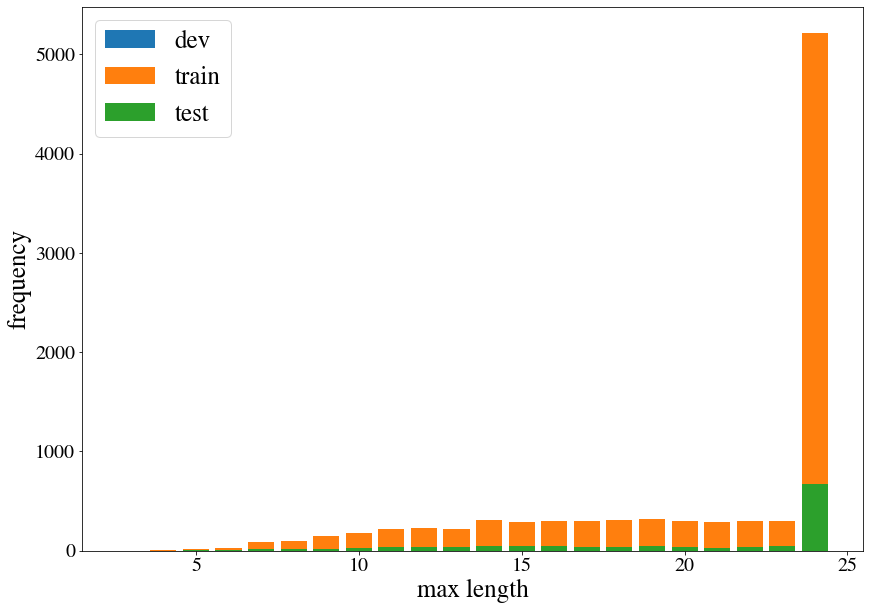

In [ ]:
import matplotlib.pyplot as plt
import collections

SMALL_SIZE = 20
MEDIUM_SIZE = 25
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 25



plt.figure(figsize=(14, 10))

for prefix in ['dev', 'train', 'test']:
  counter = collections.Counter(tokenized_sentence_len[prefix])
  plt.bar(counter.keys(), counter.values(), label=prefix)

plt.xlabel('max length')
plt.ylabel('frequency')
plt.legend()
plt.show()

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# file: mrc_ner_trainer.py

import os
import re
import argparse
import logging
from collections import namedtuple
from typing import Dict

import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from tokenizers import BertWordPieceTokenizer
from torch import Tensor
from torch.nn.modules import CrossEntropyLoss, BCEWithLogitsLoss
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup, get_polynomial_decay_schedule_with_warmup
from torch.optim import SGD

from datasets.mrc_ner_dataset import MRCNERDataset
from datasets.truncate_dataset import TruncateDataset
from datasets.collate_functions import collate_to_max_length
from metrics.query_span_f1 import QuerySpanF1
from models.bert_query_ner import BertQueryNER
from models.model_config import BertQueryNerConfig
from utils.get_parser import get_parser
from utils.random_seed import set_random_seed

import inference.mrc_ner_inference as myInference
from metrics.functional.query_span_f1 import extract_flat_spans, extract_nested_spans
import json
import copy
set_random_seed(0)


class BertLabeling(pl.LightningModule):
    def __init__(
        self,
        args #:argparse.Namespace
    ):
        """Initialize a model, tokenizer and config."""
        super().__init__()
        format = '%(asctime)s - %(name)s - %(message)s'
        if isinstance(args, argparse.Namespace):
            self.save_hyperparameters(args)
            self.args = args
            logging.basicConfig(format=format, filename=os.path.join(self.args.default_root_dir, "eval_result_log.txt"), level=logging.INFO)
        else:
            # eval mode
            TmpArgs = namedtuple("tmp_args", field_names=list(args.keys()))
            self.args = args = TmpArgs(**args)
            logging.basicConfig(format=format, filename=os.path.join(self.args.default_root_dir, "eval_test.txt"), level=logging.INFO)

        self.bert_dir = args.bert_config_dir
        self.data_dir = self.args.data_dir

        bert_config = BertQueryNerConfig.from_pretrained(args.bert_config_dir,
                                                         hidden_dropout_prob=args.bert_dropout,
                                                         attention_probs_dropout_prob=args.bert_dropout,
                                                         mrc_dropout=args.mrc_dropout,
                                                         classifier_act_func = args.classifier_act_func,
                                                         classifier_intermediate_hidden_size=args.classifier_intermediate_hidden_size)

        self.model = BertQueryNER.from_pretrained(args.bert_config_dir,
                                                  config=bert_config)
        self.vocab_path = os.path.join(self.bert_dir, "vocab.txt")
        with open(self.vocab_path, "r") as f:
            self.subtokens = [token.strip() for token in f.readlines()]
        self.idx2tokens = {}
        for token_idx, token in enumerate(self.subtokens):
            self.idx2tokens[token_idx] = token
        self.dataset_sign = args.dataset_sign
        self.queries = myInference.get_query_index_to_label_cate(self.dataset_sign)
        self.data_tokenizer = BertWordPieceTokenizer(self.vocab_path)
        logging.info(str(args.__dict__ if isinstance(args, argparse.ArgumentParser) else args))
        self.result_logger = logging.getLogger(__name__)
        self.result_logger.setLevel(logging.INFO)
        self.result_logger.info(str(args.__dict__ if isinstance(args, argparse.ArgumentParser) else args))
        self.bce_loss = BCEWithLogitsLoss(reduction="none")

        weight_sum = args.weight_start + args.weight_end + args.weight_span
        self.weight_start = args.weight_start / weight_sum
        self.weight_end = args.weight_end / weight_sum
        self.weight_span = args.weight_span / weight_sum
        self.flat_ner = args.flat
        self.span_f1 = QuerySpanF1(flat=self.flat_ner)
        self.chinese = args.chinese
        self.optimizer = args.optimizer
        self.span_loss_candidates = args.span_loss_candidates

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        parser.add_argument("--mrc_dropout", type=float, default=0.1,
                            help="mrc dropout rate")
        parser.add_argument("--bert_dropout", type=float, default=0.1,
                            help="bert dropout rate")
        parser.add_argument("--classifier_act_func", type=str, default="gelu")
        parser.add_argument("--classifier_intermediate_hidden_size", type=int, default=1024)
        parser.add_argument("--weight_start", type=float, default=1.0)
        parser.add_argument("--weight_end", type=float, default=1.0)
        parser.add_argument("--weight_span", type=float, default=1.0)
        parser.add_argument("--flat", action="store_true", help="is flat ner")
        parser.add_argument("--span_loss_candidates", choices=["all", "pred_and_gold", "pred_gold_random", "gold"],
                            default="all", help="Candidates used to compute span loss")
        parser.add_argument("--chinese", action="store_true",
                            help="is chinese dataset")
        parser.add_argument("--optimizer", choices=["adamw", "sgd", "torch.adam"], default="adamw",
                            help="loss type")
        parser.add_argument("--final_div_factor", type=float, default=1e4,
                            help="final div factor of linear decay scheduler")
        parser.add_argument("--lr_scheduler", type=str, default="onecycle", )
        parser.add_argument("--lr_mini", type=float, default=-1)
        parser.add_argument("--dataset_sign", type=str, choices=["nerel", "ontonotes4", "msra", "conll03", "ace04", "ace05"], default="nerel")
        return parser

    def configure_optimizers(self):
        """Prepare optimizer and schedule (linear warmup and decay)"""
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.args.weight_decay,
            },
            {
                "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        if self.optimizer == "adamw":
            optimizer = AdamW(optimizer_grouped_parameters,
                              betas=(0.9, 0.98),  # according to RoBERTa paper
                              lr=self.args.lr,
                              eps=self.args.adam_epsilon,)
        elif self.optimizer == "torch.adam":
            optimizer = torch.optim.AdamW(optimizer_grouped_parameters,
                                          lr=self.args.lr,
                                          eps=self.args.adam_epsilon,
                                          weight_decay=self.args.weight_decay)
        else:
            optimizer = SGD(optimizer_grouped_parameters, lr=self.args.lr, momentum=0.9)
        num_gpus = len([x for x in str(self.args.gpus).split(",") if x.strip()])
        t_total = (len(self.train_dataloader()) // (self.args.accumulate_grad_batches * num_gpus) + 1) * self.args.max_epochs
        if self.args.lr_scheduler == "onecycle":
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer, max_lr=self.args.lr, pct_start=float(self.args.warmup_steps/t_total),
                final_div_factor=self.args.final_div_factor,
                total_steps=t_total, anneal_strategy='linear'
            )
        elif self.args.lr_scheduler == "linear":
            scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=self.args.warmup_steps, num_training_steps=t_total)
        elif self.args.lr_scheduler == "polydecay":
            if self.args.lr_mini == -1:
                lr_mini = self.args.lr / 5
            else:
                lr_mini = self.args.lr_mini
            scheduler = get_polynomial_decay_schedule_with_warmup(optimizer, self.args.warmup_steps, t_total, lr_end=lr_mini)
        else:
            raise ValueError
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

    def forward(self, input_ids, attention_mask, token_type_ids):
        return self.model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    def compute_loss(self, start_logits, end_logits, span_logits,
                     start_labels, end_labels, match_labels, start_label_mask, end_label_mask):
        batch_size, seq_len = start_logits.size()

        start_float_label_mask = start_label_mask.view(-1).float()
        end_float_label_mask = end_label_mask.view(-1).float()
        match_label_row_mask = start_label_mask.bool().unsqueeze(-1).expand(-1, -1, seq_len)
        match_label_col_mask = end_label_mask.bool().unsqueeze(-2).expand(-1, seq_len, -1)
        match_label_mask = match_label_row_mask & match_label_col_mask
        match_label_mask = torch.triu(match_label_mask, 0)  # start should be less equal to end

        if self.span_loss_candidates == "all":
            # naive mask
            float_match_label_mask = match_label_mask.view(batch_size, -1).float()
        else:
            # use only pred or golden start/end to compute match loss
            start_preds = start_logits > 0
            end_preds = end_logits > 0
            if self.span_loss_candidates == "gold":
                match_candidates = ((start_labels.unsqueeze(-1).expand(-1, -1, seq_len) > 0)
                                    & (end_labels.unsqueeze(-2).expand(-1, seq_len, -1) > 0))
            elif self.span_loss_candidates == "pred_gold_random":
                gold_and_pred = torch.logical_or(
                    (start_preds.unsqueeze(-1).expand(-1, -1, seq_len)
                     & end_preds.unsqueeze(-2).expand(-1, seq_len, -1)),
                    (start_labels.unsqueeze(-1).expand(-1, -1, seq_len)
                     & end_labels.unsqueeze(-2).expand(-1, seq_len, -1))
                )
                data_generator = torch.Generator()
                data_generator.manual_seed(0)
                random_matrix = torch.empty(batch_size, seq_len, seq_len).uniform_(0, 1)
                random_matrix = torch.bernoulli(random_matrix, generator=data_generator).long()
                random_matrix = random_matrix.cuda()
                match_candidates = torch.logical_or(
                    gold_and_pred, random_matrix
                )
            else:
                match_candidates = torch.logical_or(
                    (start_preds.unsqueeze(-1).expand(-1, -1, seq_len)
                     & end_preds.unsqueeze(-2).expand(-1, seq_len, -1)),
                    (start_labels.unsqueeze(-1).expand(-1, -1, seq_len)
                     & end_labels.unsqueeze(-2).expand(-1, seq_len, -1))
                )
            match_label_mask = match_label_mask & match_candidates
            float_match_label_mask = match_label_mask.view(batch_size, -1).float()

        start_loss = self.bce_loss(start_logits.view(-1), start_labels.view(-1).float())
        start_loss = (start_loss * start_float_label_mask).sum() / start_float_label_mask.sum()
        end_loss = self.bce_loss(end_logits.view(-1), end_labels.view(-1).float())
        end_loss = (end_loss * end_float_label_mask).sum() / end_float_label_mask.sum()
        match_loss = self.bce_loss(span_logits.view(batch_size, -1), match_labels.view(batch_size, -1).float())
        match_loss = match_loss * float_match_label_mask
        match_loss = match_loss.sum() / (float_match_label_mask.sum() + 1e-10)

        return start_loss, end_loss, match_loss

    def training_step(self, batch, batch_idx):
        tf_board_logs = {
            "lr": self.trainer.optimizers[0].param_groups[0]['lr']
        }
        tokens, token_type_ids, start_labels, end_labels, start_label_mask, end_label_mask, match_labels, sample_idx, label_idx = batch

        # num_tasks * [bsz, length, num_labels]
        attention_mask = (tokens != 0).long()
        start_logits, end_logits, span_logits = self(tokens, attention_mask, token_type_ids)

        start_loss, end_loss, match_loss = self.compute_loss(start_logits=start_logits,
                                                             end_logits=end_logits,
                                                             span_logits=span_logits,
                                                             start_labels=start_labels,
                                                             end_labels=end_labels,
                                                             match_labels=match_labels,
                                                             start_label_mask=start_label_mask,
                                                             end_label_mask=end_label_mask
                                                             )

        total_loss = self.weight_start * start_loss + self.weight_end * end_loss + self.weight_span * match_loss

        tf_board_logs[f"train_loss"] = total_loss
        tf_board_logs[f"start_loss"] = start_loss
        tf_board_logs[f"end_loss"] = end_loss
        tf_board_logs[f"match_loss"] = match_loss

        return {'loss': total_loss, 'log': tf_board_logs}

    def validation_step(self, batch, batch_idx):
        output = {}
        tokens, token_type_ids, start_labels, end_labels, start_label_mask, end_label_mask, match_labels, sample_idx, label_idx = batch

        attention_mask = (tokens != 0).long()
        start_logits, end_logits, span_logits = self(tokens, attention_mask, token_type_ids)

        start_loss, end_loss, match_loss = self.compute_loss(start_logits=start_logits,
                                                             end_logits=end_logits,
                                                             span_logits=span_logits,
                                                             start_labels=start_labels,
                                                             end_labels=end_labels,
                                                             match_labels=match_labels,
                                                             start_label_mask=start_label_mask,
                                                             end_label_mask=end_label_mask
                                                             )

        total_loss = self.weight_start * start_loss + self.weight_end * end_loss + self.weight_span * match_loss

        output[f"val_loss"] = total_loss
        output[f"start_loss"] = start_loss
        output[f"end_loss"] = end_loss
        output[f"match_loss"] = match_loss

        start_preds, end_preds = start_logits > 0, end_logits > 0
        span_f1_stats = self.span_f1(start_preds=start_preds, end_preds=end_preds, match_logits=span_logits,
                                     start_label_mask=start_label_mask, end_label_mask=end_label_mask,
                                     match_labels=match_labels)
        output["span_f1_stats"] = span_f1_stats

        return output

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}

        all_counts = torch.stack([x[f'span_f1_stats'] for x in outputs]).view(-1, 3).sum(0)
        span_tp, span_fp, span_fn = all_counts
        span_recall = span_tp / (span_tp + span_fn + 1e-10)
        span_precision = span_tp / (span_tp + span_fp + 1e-10)
        span_f1 = span_precision * span_recall * 2 / (span_recall + span_precision + 1e-10)
        tensorboard_logs[f"span_precision"] = span_precision
        tensorboard_logs[f"span_recall"] = span_recall
        tensorboard_logs[f"span_f1"] = span_f1
        self.result_logger.info(f"EVAL INFO -> current_epoch is: {self.trainer.current_epoch}, current_global_step is: {self.trainer.global_step} ")
        self.result_logger.info(f"EVAL INFO -> valid_f1 is: {span_f1}; precision: {span_precision}, recall: {span_recall}.")

        return {'val_loss': avg_loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_idx):
        """"""
        output = {}
        tokens, token_type_ids, start_labels, end_labels, start_label_mask, end_label_mask, match_labels, sample_idx, label_idx = batch

        attention_mask = (tokens != 0).long()
        start_logits, end_logits, span_logits = self(tokens, attention_mask, token_type_ids)

        start_preds, end_preds = start_logits > 0, end_logits > 0
        span_f1_stats = self.span_f1(start_preds=start_preds, end_preds=end_preds, match_logits=span_logits,
                                     start_label_mask=start_label_mask, end_label_mask=end_label_mask,
                                     match_labels=match_labels)
        output["span_f1_stats"] = span_f1_stats

        return output

    def test_epoch_end(self, outputs) -> Dict[str, Dict[str, Tensor]]:
        tensorboard_logs = {}

        all_counts = torch.stack([x[f'span_f1_stats'] for x in outputs]).view(-1, 3).sum(0)
        span_tp, span_fp, span_fn = all_counts
        span_recall = span_tp / (span_tp + span_fn + 1e-10)
        span_precision = span_tp / (span_tp + span_fp + 1e-10)
        span_f1 = span_precision * span_recall * 2 / (span_recall + span_precision + 1e-10)
        print(f"TEST INFO -> test_f1 is: {span_f1} precision: {span_precision}, recall: {span_recall}")
        self.result_logger.info(f"TEST INFO -> test_f1 is: {span_f1} precision: {span_precision}, recall: {span_recall}")
        return {'log': tensorboard_logs}

    def train_dataloader(self) -> DataLoader:
        return self.get_dataloader("train")

    def val_dataloader(self) -> DataLoader:
        return self.get_dataloader("dev")

    def test_dataloader(self) -> DataLoader:
        return self.get_dataloader("test")

    def get_dataloader(self, prefix="train", limit: int = None) -> DataLoader:
        """get training dataloader"""
        """
        load_mmap_dataset
        """
        json_path = os.path.join(self.data_dir, f"mrc-ner.{prefix}")
        #vocab_path = os.path.join(self.bert_dir, "vocab.txt")
        dataset = MRCNERDataset(json_path=json_path,
                                tokenizer=self.data_tokenizer,
                                #tokenizer=BertWordPieceTokenizer(self.vocab_path),
                                max_length=self.args.max_length,
                                is_chinese=self.chinese,
                                pad_to_maxlen=False
                                )

        if limit is not None:
            dataset = TruncateDataset(dataset, limit)

        dataloader = DataLoader(
            dataset=dataset,
            batch_size=self.args.batch_size,
            num_workers=self.args.workers,
            shuffle=True if prefix == "train" else False,
            collate_fn=collate_to_max_length
        )

        return dataloader
    def predict_step(self, batch, batch_idx: int , dataloader_idx: int = None):
        return self(batch)
    def query_dataloader(self, sentence: str):
        res = []
        d = {"context": sentence, "start_position":[], "end_position":[]}
        for key, value in self.queries.items():
            out = copy.deepcopy(d)
            out["query"] = value
            out["qas_id"] = f"{0}.{key}"
            res.append(out)
        json_path = os.path.join(self.data_dir, f"mrc-ner.query")
        with open(json_path, 'w', encoding='utf-8') as f:
            json.dump(res, f, ensure_ascii=False, indent=4)        
        return self.get_dataloader("query")
    def my_predict(self, sentence):
        dataloader = self.query_dataloader(sentence)
        for batch in dataloader:
            tokens, token_type_ids, start_labels, end_labels, start_label_mask, end_label_mask, match_labels, sample_idx, label_idx = batch
            attention_mask = (tokens != 0).long()

            start_logits, end_logits, span_logits = self.model(tokens, attention_mask=attention_mask, token_type_ids=token_type_ids)
            start_preds, end_preds, span_preds = start_logits > 0, end_logits > 0, span_logits > 0

            subtokens_idx_lst = tokens.numpy().tolist()[0]
            subtokens_lst = [self.idx2tokens[item] for item in subtokens_idx_lst]
            query2label_dict = myInference.get_query_index_to_label_cate(self.dataset_sign)
            label_cate = query2label_dict[label_idx.item()]
            readable_input_str = self.data_tokenizer.decode(subtokens_idx_lst, skip_special_tokens=True)
            match_preds = span_logits > 0
            entities_info = extract_nested_spans(start_preds, end_preds, match_preds, start_label_mask, end_label_mask, pseudo_tag=label_cate)

            entity_lst = []

            if len(entities_info) != 0:
                for entity_info in entities_info:
                    start, end = entity_info[0], entity_info[1]
                    entity_string = " ".join(subtokens_lst[start: end+1 ])
                    entity_string = entity_string.replace(" ##", "")
                    entity_lst.append((start, end+1, entity_string, entity_info[2]))
            return readable_input_str, entity_lst

def find_best_checkpoint_on_dev(output_dir: str, log_file: str = "eval_result_log.txt", only_keep_the_best_ckpt: bool = False):
    with open(os.path.join(output_dir, log_file)) as f:
        log_lines = f.readlines()

    F1_PATTERN = re.compile(r"span_f1 reached \d+\.\d* \(best")
    # val_f1 reached 0.00000 (best 0.00000)
    CKPT_PATTERN = re.compile(r"saving model to \S+ as top")
    checkpoint_info_lines = []
    for log_line in log_lines:
        if "saving model to" in log_line:
            checkpoint_info_lines.append(log_line)
    # example of log line
    # Epoch 00000: val_f1 reached 0.00000 (best 0.00000), saving model to /data/xiaoya/outputs/0117/debug_5_12_2e-5_0.001_0.001_275_0.1_1_0.25/checkpoint/epoch=0.ckpt as top 20
    best_f1_on_dev = 0
    best_checkpoint_on_dev = ""
    for checkpoint_info_line in checkpoint_info_lines:
        current_f1 = float(
            re.findall(F1_PATTERN, checkpoint_info_line)[0].replace("span_f1 reached ", "").replace(" (best", ""))
        current_ckpt = re.findall(CKPT_PATTERN, checkpoint_info_line)[0].replace("saving model to ", "").replace(
            " as top", "")

        if current_f1 >= best_f1_on_dev:
            if only_keep_the_best_ckpt and len(best_checkpoint_on_dev) != 0:
                os.remove(best_checkpoint_on_dev)
            best_f1_on_dev = current_f1
            best_checkpoint_on_dev = current_ckpt

    return best_f1_on_dev, best_checkpoint_on_dev
import inspect

def main():
    """main"""
    parser = get_parser()

    # add model specific args
    parser = BertLabeling.add_model_specific_args(parser)

    # add all the available trainer options to argparse
    # ie: now --gpus --num_nodes ... --fast_dev_run all work in the cli
    parser = Trainer.add_argparse_args(parser)

    args = parser.parse_args()
    print("Given args:", args)
    model = BertLabeling(args)
    if args.pretrained_checkpoint:
        model.load_state_dict(torch.load(args.pretrained_checkpoint,
                                         map_location=torch.device('cpu'))["state_dict"])
    print(inspect.signature(ModelCheckpoint))

    checkpoint_callback = ModelCheckpoint(
        filepath=args.default_root_dir,
     #   every_n_epochs=args.every_n_epochs,
        save_top_k=args.max_keep_ckpt,
        verbose=True,
        monitor="span_f1",
        period=args.every_n_epochs, #-1
        mode="max",
    )
    Ngpu = torch.cuda.device_count()
    print(f" GPU_NUM={Ngpu}")
    for n in range(Ngpu):
        namegpu = torch.cuda.get_device_name(n)
        print(f"GPU info={namegpu}")
    trainer = Trainer.from_argparse_args(
        args,
        checkpoint_callback=checkpoint_callback,
        deterministic=True,
        default_root_dir=args.default_root_dir
    )

    trainer.fit(model)

    # after training, use the model checkpoint which achieves the best f1 score on dev set to compute the f1 on test set.
    best_f1_on_dev, path_to_best_checkpoint = find_best_checkpoint_on_dev(args.default_root_dir, )
    model.result_logger.info("=&" * 20)
    model.result_logger.info(f"Best F1 on DEV is {best_f1_on_dev}")
    model.result_logger.info(f"Best checkpoint on DEV set is {path_to_best_checkpoint}")
    checkpoint = torch.load(path_to_best_checkpoint)
    model.load_state_dict(checkpoint['state_dict'])
    model.result_logger.info("=&" * 20)




In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# file: mrc_ner_dataset.py

import json
import torch
from tokenizers import BertWordPieceTokenizer
from torch.utils.data import Dataset


class MRCNERDataset(Dataset):
    """
    MRC NER Dataset
    Args:
        json_path: path to mrc-ner style json
        tokenizer: BertTokenizer
        max_length: int, max length of query+context
        possible_only: if True, only use possible samples that contain answer for the query/context
        is_chinese: is chinese dataset
    """
    def __init__(self, json_path, tokenizer: BertWordPieceTokenizer, max_length: int = 512, possible_only=False,
                 is_chinese=False, pad_to_maxlen=False):
        self.all_data = json.load(open(json_path, encoding="utf-8"))
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.possible_only = possible_only
        if self.possible_only:
            self.all_data = [
                x for x in self.all_data if x["start_position"]
            ]
        self.is_chinese = is_chinese
        self.pad_to_maxlen = pad_to_maxlen

    def __len__(self):
        return len(self.all_data)

    def __getitem__(self, item):
        """
        Args:
            item: int, idx
        Returns:
            tokens: tokens of query + context, [seq_len]
            token_type_ids: token type ids, 0 for query, 1 for context, [seq_len]
            start_labels: start labels of NER in tokens, [seq_len]
            end_labels: end labels of NER in tokens, [seq_len]
            label_mask: label mask, 1 for counting into loss, 0 for ignoring. [seq_len]
            match_labels: match labels, [seq_len, seq_len]
            sample_idx: sample id
            label_idx: label id
        """
        data = self.all_data[item]
        tokenizer = self.tokenizer
        print(f'data {data}', flush=True)
        #print('Passed 0', flush=True)
        #print(f'tokenizer {tokenizer}', flush=True)
        qas_id = data.get("qas_id", "0.0")
        print(f"qas_id={qas_id}")
        sample_idx, label_idx = qas_id.split(".")
        sample_idx = torch.LongTensor([int(sample_idx)])
        label_idx = torch.LongTensor([int(label_idx)])

        query = data["query"]
        context = data["context"]
        start_positions = data["start_position"]
        end_positions = data["end_position"]

        if self.is_chinese:
            context = "".join(context.split())
            end_positions = [x+1 for x in end_positions]
        else:
            # add space offsets
            words = context.split()
            start_positions = [x + sum([len(w) for w in words[:x]]) for x in start_positions]
            end_positions = [x + sum([len(w) for w in words[:x + 1]]) for x in end_positions]
        print(f'words {words}')
        print(f'start_positions {start_positions}')
        print(f'end_positions {end_positions}')
        query_context_tokens = tokenizer.encode(query, context, add_special_tokens=True)
        tokens = query_context_tokens.ids
        type_ids = query_context_tokens.type_ids
        offsets = query_context_tokens.offsets #(0, 0) - for [CLS], [SEP]; (a, b) - offset of a word, b is not included; indexation is started from 0 for both query and context.
        print(f'tokens {tokens}')
        print(f'type_ids {type_ids}')
        print(f'offsets {offsets}')

        # find new start_positions/end_positions, considering
        # 1. we add query tokens at the beginning
        # 2. word-piece tokenize
        origin_offset2token_idx_start = {}
        origin_offset2token_idx_end = {}
        for token_idx in range(len(tokens)):
            # skip query tokens
            if type_ids[token_idx] == 0:
                continue
            token_start, token_end = offsets[token_idx]
            # skip [CLS] or [SEP]
            if token_start == token_end == 0:
                continue
            origin_offset2token_idx_start[token_start] = token_idx
            origin_offset2token_idx_end[token_end] = token_idx
        # print(f'origin_offset2token_idx_start {origin_offset2token_idx_start}', flush=True)
        # print(f'origin_offset2token_idx_end  {origin_offset2token_idx_end}', flush=True)
        new_start_positions = [origin_offset2token_idx_start[start] for start in start_positions]
        #print(f'Passed 1', flush=True)
        new_end_positions = [origin_offset2token_idx_end[end] for end in end_positions]
        #print(f'Passed 2', flush=True)
        # print(f'new_start_positions {new_start_positions}')
        # print(f'new_end_positions {new_end_positions}')
        ######### check:
        xx = []
        for t in tokens:
          xx.append(data_tokenizer.id_to_token(t))
        # for t in zip(new_start_positions, new_end_positions):
        #   print(f"text[{t[0]}:{t[1]}]={xx[t[0]:t[1]+1]}")
        #########
        label_mask = [
            (0 if type_ids[token_idx] == 0 or offsets[token_idx] == (0, 0) else 1) #0 for [CLS], [SEP] and (0, 0)
            for token_idx in range(len(tokens))
        ]
        start_label_mask = label_mask.copy()
        end_label_mask = label_mask.copy()
        print(f'label_mask {label_mask}')
        # the start/end position must be whole word
        if not self.is_chinese:
            for token_idx in range(len(tokens)):
                current_word_idx = query_context_tokens.word_ids[token_idx]
                next_word_idx = query_context_tokens.word_ids[token_idx+1] if token_idx+1 < len(tokens) else None
                prev_word_idx = query_context_tokens.word_ids[token_idx-1] if token_idx-1 > 0 else None
                if prev_word_idx is not None and current_word_idx == prev_word_idx:
                    start_label_mask[token_idx] = 0
                if next_word_idx is not None and current_word_idx == next_word_idx:
                    end_label_mask[token_idx] = 0

        
        assert all(start_label_mask[p] != 0 for p in new_start_positions)
        assert all(end_label_mask[p] != 0 for p in new_end_positions)

        assert len(new_start_positions) == len(new_end_positions) == len(start_positions)
        assert len(label_mask) == len(tokens)
        start_labels = [(1 if idx in new_start_positions else 0)
                        for idx in range(len(tokens))]
        end_labels = [(1 if idx in new_end_positions else 0)
                      for idx in range(len(tokens))]
        
        for i in range(len(start_label_mask)):
          print(f"text: {xx[i]}, start_label_mask: {start_label_mask[i]}, end_label_mask: {end_label_mask[i]}, start_labels:{start_labels[i]}, end_labels: {end_labels[i]}")
        # truncate
        tokens = tokens[: self.max_length]
        type_ids = type_ids[: self.max_length]
        start_labels = start_labels[: self.max_length]
        end_labels = end_labels[: self.max_length]
        start_label_mask = start_label_mask[: self.max_length]
        end_label_mask = end_label_mask[: self.max_length]

        # make sure last token is [SEP]
        sep_token = tokenizer.token_to_id("[SEP]")
        if tokens[-1] != sep_token:
            assert len(tokens) == self.max_length
            tokens = tokens[: -1] + [sep_token]
            start_labels[-1] = 0
            end_labels[-1] = 0
            start_label_mask[-1] = 0
            end_label_mask[-1] = 0

        if self.pad_to_maxlen:
            tokens = self.pad(tokens, 0)
            type_ids = self.pad(type_ids, 1)
            start_labels = self.pad(start_labels)
            end_labels = self.pad(end_labels)
            start_label_mask = self.pad(start_label_mask)
            end_label_mask = self.pad(end_label_mask)

        seq_len = len(tokens)
        match_labels = torch.zeros([seq_len, seq_len], dtype=torch.long) # a square matrix where i, j correspond to the indices of the beginning and ending of the entities
        for start, end in zip(new_start_positions, new_end_positions):
            if start >= seq_len or end >= seq_len:
                continue
            match_labels[start, end] = 1
        torch.set_printoptions(threshold=10_000)
        # print(f'size:{match_labels.size()} match_labels:{match_labels}')
        return [
            torch.LongTensor(tokens),
            torch.LongTensor(type_ids),
            torch.LongTensor(start_labels),
            torch.LongTensor(end_labels),
            torch.LongTensor(start_label_mask),
            torch.LongTensor(end_label_mask),
            match_labels,
            sample_idx,
            label_idx
        ]

    def pad(self, lst, value=0, max_length=None):
        max_length = max_length or self.max_length
        while len(lst) < max_length:
            lst.append(value)
        return lst


def run_dataset():
    """test dataset"""
    import os
    from datasets.collate_functions import collate_to_max_length
    from torch.utils.data import DataLoader
    # zh datasets
    bert_path = "/data/nfsdata/nlp/BERT_BASE_DIR/chinese_L-12_H-768_A-12"
    vocab_file = os.path.join(bert_path, "vocab.txt")
    # json_path = "/mnt/mrc/zh_msra/mrc-ner.test"
    json_path = "/data/xiaoya/datasets/mrc_ner/zh_msra/mrc-ner.train"
    is_chinese = True

    # en datasets
    # bert_path = "/mnt/mrc/bert-base-uncased"
    # json_path = "/mnt/mrc/ace2004/mrc-ner.train"
    # json_path = "/mnt/mrc/genia/mrc-ner.train"
    # is_chinese = False

    vocab_file = os.path.join(bert_path, "vocab.txt")
    tokenizer = BertWordPieceTokenizer(vocab_file)
    dataset = MRCNERDataset(json_path=json_path, tokenizer=tokenizer,
                            is_chinese=is_chinese)

    dataloader = DataLoader(dataset, batch_size=1,
                            collate_fn=collate_to_max_length)

    for batch in dataloader:
        for tokens, token_type_ids, start_labels, end_labels, start_label_mask, end_label_mask, match_labels, sample_idx, label_idx in zip(*batch):
            tokens = tokens.tolist()
            start_positions, end_positions = torch.where(match_labels > 0)
            start_positions = start_positions.tolist()
            end_positions = end_positions.tolist()
            print(start_labels.numpy().tolist())

            tmp_start_position = []
            for tmp_idx, tmp_label in enumerate(start_labels.numpy().tolist()):
                if tmp_label != 0:
                    tmp_start_position.append(tmp_idx)

            tmp_end_position = []
            for tmp_idx, tmp_label in enumerate(end_labels.numpy().tolist()):
                if tmp_label != 0:
                    tmp_end_position.append(tmp_idx)

            if not start_positions:
                continue
            print("="*20)
            print(f"len: {len(tokens)}", tokenizer.decode(tokens, skip_special_tokens=False))
            for start, end in zip(start_positions, end_positions):
                print(str(sample_idx.item()), str(label_idx.item()) + "\t" + tokenizer.decode(tokens[start: end+1]))

            print("!!!"*20)
            for start, end in zip(tmp_start_position, tmp_end_position):
                print(str(sample_idx.item()), str(label_idx.item()) + "\t" + tokenizer.decode(tokens[start: end + 1]))


# if __name__ == '__main__':
#     run_dataset()


In [ ]:
from tokenizers import BertWordPieceTokenizer
prefix='train'
input_file = f'/content/drive/MyDrive/Diploma_paper/NEREL_01/{prefix}.json'
output_file = f'/content/drive/MyDrive/Diploma_paper/NEREL_MRC/mrc-ner.{prefix}'
tag2query_file = f'/content/drive/MyDrive/Diploma_paper/mrc_preprocess_wanglaiki/mrc-wanglaiki/data_preprocess/queries/ent_nerel.json'
vocab_path = f'/content/drive/MyDrive/Diploma_paper/sbert_large_nlu_ru/vocab.txt'

model_ckpt = ''
dataset_sign = "nerel"
max_length = 512
batch_size = 7
workers = 0

queries = myInference.get_query_index_to_label_cate(dataset_sign)
data_tokenizer = BertWordPieceTokenizer(vocab_path)
dataset = MRCNERDataset(json_path = output_file, 
                        tokenizer=data_tokenizer, 
                        max_length=130, 
                        possible_only=False, is_chinese=False, pad_to_maxlen=False)

dataloader = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            num_workers=workers,
            shuffle=True if prefix == "train" else False,
            collate_fn=collate_to_max_length  # pad to maximum length of this batch
                                              # batch: a batch of samples, each contains a list of field data(Tensor):
                                              #   tokens, token_type_ids, start_labels, end_labels, start_label_mask, end_label_mask, match_labels, sample_idx, label_idx
                                              # Returns: output: list of field batched data, which shape is [batch, max_length]
        )

parser = get_parser()
args = parser.parse_args()
print(f"args:{args}")

trained_mrc_ner_model = myTrain.BertLabeling.load_from_checkpoint(
    checkpoint_path=args.model_ckpt,
    hparams_file=args.hparams_file,
    map_location=None,
    batch_size=1,
    max_length=args.max_length,
    workers=0)

In [ ]:
# dataset[0]
for i,batch in enumerate(dataloader):
  tokens, token_type_ids, start_labels, end_labels, start_label_mask, end_label_mask, match_labels, sample_idx, label_idx = batch
  break

data {'context': 'Он стал 3 - м Болгарским Патриархом в новейшее время , после уврачевания схизмы Болгарской Православной Церкви с Константинопольским Патриархатом .', 'query': 'Найди в тексте обозначение меры воздействия на того, кто совершил правонарушение или преступление', 'start_position': [], 'end_position': [], 'qas_id': '111787.21'}
qas_id=111787.21
words ['Он', 'стал', '3', '-', 'м', 'Болгарским', 'Патриархом', 'в', 'новейшее', 'время', ',', 'после', 'уврачевания', 'схизмы', 'Болгарской', 'Православной', 'Церкви', 'с', 'Константинопольским', 'Патриархатом', '.']
start_positions []
end_positions []
tokens [101, 2775, 687, 113, 11759, 36803, 5425, 887, 29993, 2014, 660, 1093, 121, 1309, 9227, 77664, 967, 13267, 102, 795, 1579, 168, 133, 115, 17480, 1313, 71723, 113, 12695, 376, 378, 2230, 1012, 121, 934, 56485, 649, 12223, 825, 85397, 22632, 17480, 702, 378, 7662, 110870, 5231, 110, 109293, 4659, 1313, 20565, 930, 126, 102]
type_ids [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# with open(vocab_path, "r") as f:
#     subtokens = [token.strip() for token in f.readlines()] # Leading and trailing whitespaces are removed
# idx2tokens = {}
# for token_idx, token in enumerate(subtokens):
#     idx2tokens[token_idx] = token

query2label_dict = get_query_index_to_label_cate(dataset_sign)

for batch in data_loader:
    tokens, token_type_ids, start_labels, end_labels, start_label_mask, end_label_mask, match_labels, sample_idx, label_idx = batch
    attention_mask = (tokens != 0).long()
    #print('batch:', batch)
    start_logits, end_logits, span_logits = trained_mrc_ner_model.model(tokens, attention_mask=attention_mask, token_type_ids=token_type_ids)
    start_preds, end_preds, span_preds = start_logits > 0, end_logits > 0, span_logits > 0

    subtokens_idx_lst = tokens.numpy().tolist()[0]
    subtokens_lst = [data_tokenizer.id_to_token(item) for item in subtokens_idx_lst]
    # subtokens_lst = [idx2tokens[item] for item in subtokens_idx_lst]
    #print(query2label_dict, label_idx.item())
    label_cate = query2label_dict[label_idx.item()]
    readable_input_str = data_tokenizer.decode(subtokens_idx_lst, skip_special_tokens=True)
    print('label_cate:', label_cate)
    print('readable_input_str:', readable_input_str)
  
    match_preds = span_logits > 0
    entities_info = extract_nested_spans(start_preds, end_preds, match_preds, start_label_mask, end_label_mask, pseudo_tag=label_cate)

    entity_lst = []

    if len(entities_info) != 0:
        for entity_info in entities_info:
            start, end = entity_info[0], entity_info[1]
            entity_string = " ".join(subtokens_lst[start: end+1 ])
            entity_string = entity_string.replace(" ##", "")
            entity_lst.append((start, end+1, entity_string, entity_info[2]))
    break
    print("*="*10)
    print(f"Given input: {readable_input_str}")
    print(f"Model predict: {entity_lst}")

In [ ]:
xx = []
for t in [101, 2775, 687, 113, 11759, 36803, 1847, 121, 14377, 12576, 121, 3481, 967, 14704, 102, 9286, 27203, 40890, 2248, 35919, 97721, 40890, 2248, 35919, 97721, 2900, 2749, 113, 4342, 1049, 3526, 6784, 78520, 6785, 121, 7913, 121, 27203, 121, 2598, 8206, 17589, 669, 40890, 2248, 35919, 97721, 126, 102]:
  xx.append(data_tokenizer.id_to_token(t))


for t in zip([21, 43, 17, 41], [24, 46, 20, 42]):
  print(xx[t[0]:t[1]+1])


['вита', '##лии', 'косто', '##маров']
['вита', '##лии', 'косто', '##маров']
['вита', '##лии', 'косто', '##маров']
['пушки', '##на']


In [ ]:
encoded_input['input_ids'].size()

torch.Size([2, 11])

In [ ]:
encoded_input

{'input_ids': tensor([[  101,  6571,   177,   785,  9229,  1196,   161,   102,     0,     0,
             0],
        [  101,   106,  3824,   121,   693,  6397, 12498, 44900,  4420,   161,
           102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [ ]:
for sid in encoded_input['input_ids']:
  print(tokenizer.convert_ids_to_tokens(sid))

['[CLS]', 'привет', '!', 'как', 'твои', 'дела', '?', '[SEP]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'а', 'правда', ',', 'что', '42', 'твое', 'любимое', 'число', '?', '[SEP]']


In [ ]:
!